#### This notebook analyses the heat content and SST responses in the abrupt ACCESS-OM2 experiments.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Client Scheduler: tcp://127.0.0.1:42411 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 128.85 GB


In [3]:
### Generate new session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,24764
1,1deg_jra55_ryf_rcp45warm_x1_spinup500,42426
2,1deg_jra55_ryf_rcp45cool_x1_spinup500,42426
3,1deg_jra55_ryf_warm_0sat_8dwlw_spinup500,21206
4,1deg_jra55_ryf_warm_1.5sat_0dwlw_spinup500,21206
5,1deg_jra55_ryf_RCPwarm_humid_x1,42426
6,1deg_jra55_ryf_RCPwarm_humid_x2,42207
7,1deg_jra55_ryf_RCPcool_humid_x1,42207
8,1deg_jra55_ryf_RCPcool_humid_x2,42426
9,1deg_jra55_ryf_wcwc_step_test1,2108


In [4]:
yr_beg = '2400-01-16'
yr_end = '2499-12-31'

expt = '1deg_jra55_ryf_cont'
var = 'temp'
frequency = '1 monthly'
temp_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end).chunk(chunks='auto') 

In [5]:
temp_cont

,Array,Chunk
Bytes,25.92 GB,129.60 MB
Shape,"(1200, 50, 300, 360)","(6, 50, 300, 360)"
Count,19500 Tasks,200 Chunks
Type,float32,numpy.ndarray


In [5]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp'
frequency = '1 monthly'
temp_cool = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [6]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp'
frequency = '1 monthly'
temp_warm = cc.querying.getvar(expt, var, session, frequency = frequency, end_time = yr_end).chunk(chunks='auto') 

In [6]:
expt = '1deg_jra55_ryf_RCPcool_humid_x2'
var = 'temp'
frequency = '1 monthly'
temp_RCPcool_humid_x2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [8]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
var = 'temp'
frequency = '1 monthly'
temp_RCPwarm_humid_x2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [9]:
expt = '1deg_jra55_ryf_rcp45cool_x1_spinup500'
var = 'temp'
frequency = '1 monthly'
temp_coolx1 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [10]:
expt = '1deg_jra55_ryf_rcp45cool_x2_spinup500'
var = 'temp'
frequency = '1 monthly'
temp_coolx2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [6]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500'
var = 'temp'
frequency = '1 monthly'
temp_warmx1 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto')

In [12]:
expt = '1deg_jra55_ryf_rcp45warm_x2_spinup500'
var = 'temp'
frequency = '1 monthly'
temp_warmx2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto')

In [5]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500_test'
var = 'temp'
frequency = '1 monthly'
temp_warmx1_test = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto')

In [12]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500_test1'
var = 'temp'
frequency = '1 monthly'
temp_warmx1_test1 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto')

In [6]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500_test2'
var = 'temp'
frequency = '1 monthly'
temp_warmx1_test2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto')

### Calculate global average temperature

In [9]:
expt = '1deg_jra55_ryf_cont'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_cont_ave = (temp_cont * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [94]:
expt = '1deg_jra55_ryf_wcwc_step_test'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session, start_time = yr_beg) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_step_test_ave = (temp_step_test * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [10]:
expt = '1deg_jra55_ryf_wcwc_step_test1'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session, start_time = yr_beg) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_step_test1_ave = (temp_step_test1 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [11]:
expt = '1deg_jra55_ryf_wcwc_step_test2'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session, start_time = yr_beg) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_step_test2_ave = (temp_step_test2 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [14]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_RCPcool_humid_x1_ave = (temp_RCPcool_humid_x1 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [15]:
expt = '1deg_jra55_ryf_RCPcool_humid_x2'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_RCPcool_humid_x2_ave = (temp_RCPcool_humid_x2 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [96]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session, end_time = yr_end) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_RCPwarm_humid_x1_ave = (temp_RCPwarm_humid_x1 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [17]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_RCPwarm_humid_x2_ave = (temp_RCPwarm_humid_x2 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [18]:
expt = '1deg_jra55_ryf_rcp45cool_x1_spinup500'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_coolx1_ave = (temp_coolx1 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [19]:
expt = '1deg_jra55_ryf_rcp45cool_x2_spinup500'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_coolx2_ave = (temp_coolx2 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [16]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_warmx1_ave = (temp_warmx1 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [21]:
expt = '1deg_jra55_ryf_rcp45warm_x2_spinup500'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_warmx2_ave = (temp_warmx2 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [8]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500_test'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_warmx1_test_ave = (temp_warmx1_test * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [13]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500_test1'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_warmx1_test1_ave = (temp_warmx1_test1 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [9]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500_test2'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_warmx1_test2_ave = (temp_warmx1_test2 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [28]:
expt = '1deg_jra55_ryf_warm_1.5sat_0dwlw_spinup500'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_warm_Tonly_ave = (temp_warm_Tonly * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [29]:
expt = '1deg_jra55_ryf_warm_0sat_8dwlw_spinup500'
var = 'dzt'
dzt = cc.querying.getvar(expt, var, session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) # Volume of cells
Vol = dVol.sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) # total volume of ocean

temp_warm_RADonly_ave = (temp_warm_RADonly * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean']) / Vol

In [12]:
temp_cont_ave = temp_cont_ave.load()#.groupby('time.year').mean(dim='time').load()
temp_step_test1_ave = temp_step_test1_ave.load()#.groupby('time.year').mean(dim='time').load()
temp_step_test2_ave = temp_step_test2_ave.load()#.groupby('time.year').mean(dim='time').load()

In [22]:
temp_cont_ave = temp_cont_ave.groupby('time.year').mean(dim='time').load()

temp_RCPcool_humid_x1_ave = temp_RCPcool_humid_x1_ave.groupby('time.year').mean(dim='time').load()
temp_RCPcool_humid_x2_ave = temp_RCPcool_humid_x2_ave.groupby('time.year').mean(dim='time').load()
temp_RCPwarm_humid_x1_ave = temp_RCPwarm_humid_x1_ave.groupby('time.year').mean(dim='time').load()
temp_RCPwarm_humid_x2_ave = temp_RCPwarm_humid_x2_ave.groupby('time.year').mean(dim='time').load()

temp_coolx1_ave = temp_coolx1_ave.groupby('time.year').mean(dim='time').load()
temp_coolx2_ave = temp_coolx2_ave.groupby('time.year').mean(dim='time').load()
temp_warmx1_ave = temp_warmx1_ave.groupby('time.year').mean(dim='time').load()
temp_warmx2_ave = temp_warmx2_ave.groupby('time.year').mean(dim='time').load()

In [40]:
# Trend in control heat content: fit a cubic

def cubic(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

t = temp_cont_ave['year']
popt, pcov = curve_fit(cubic, t, temp_cont_ave)
temp_ave_trend = cubic(t, *popt)

plt.figure(figsize=(13,9))
(temp_ave_trend - 273.15).plot(color='r', linestyle='--', label='Fit')
(temp_cont_ave - 273.15).plot(color='b', label='Data')
plt.legend()
plt.title('Drift in control global average temperature', fontsize=13)
plt.ylabel('Temperature (deg C)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid()
#plt.savefig('drift.jpg')

plt.figure(figsize=(13,9))
(temp_cool_ave-273.15).plot(label='cool', color='b')
(temp_warm_ave-273.15).plot(label='warm', color='r')
(temp_cont_ave-273.15).plot(label='cont', color='g')

KeyError: 'year'

#### Plotting globally averaged temperature over time

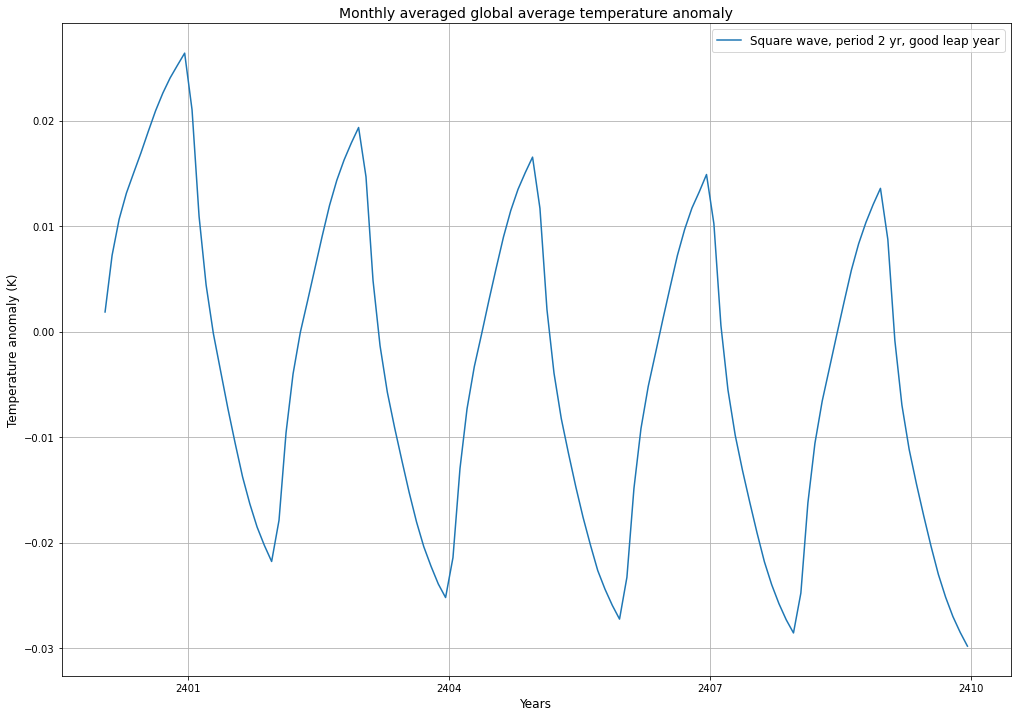

In [83]:
fig = plt.figure(figsize = (17,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})

# step_test_anom_plot = xr.concat([zero, temp_step_test_ave - temp_cont_ave], dim='year')
step_test2_anom_plot = temp_step_test2_ave - temp_cont_ave

step_test2_anom_plot.plot(label='Square wave, period 2 yr, good leap year')

plt.title('Monthly averaged global average temperature anomaly', fontsize=14)
plt.ylabel('Temperature anomaly (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
# plt.savefig('ave_temp_step_test.jpg')

In [89]:
step_test2_anom_plot['time'][np.where(step_test2_anom_plot == np.max(step_test2_anom_plot))[0][0]]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2400, 12, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2400-12-16 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP
    bounds:          time_bounds

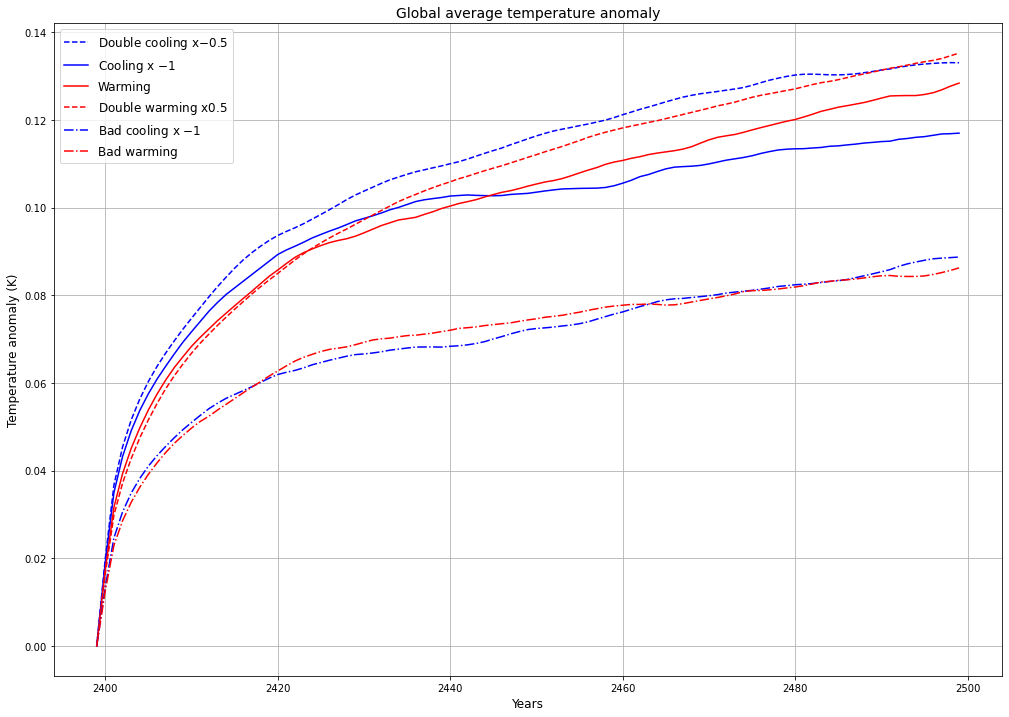

In [48]:
plt.figure(figsize = (17,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})

RCPcool_humid_x1_anom_plot = xr.concat([zero, temp_RCPcool_humid_x1_ave - temp_cont_ave], dim='year')
RCPcool_humid_x2_anom_plot = xr.concat([zero, temp_RCPcool_humid_x2_ave - temp_cont_ave], dim='year')
RCPwarm_humid_x1_anom_plot = xr.concat([zero, temp_RCPwarm_humid_x1_ave - temp_cont_ave], dim='year')
RCPwarm_humid_x2_anom_plot = xr.concat([zero, temp_RCPwarm_humid_x2_ave - temp_cont_ave], dim='year')

coolx1_anom_plot = xr.concat([zero, temp_coolx1_ave - temp_cont_ave], dim='year')
coolx2_anom_plot = xr.concat([zero, temp_coolx2_ave - temp_cont_ave], dim='year')
warmx1_anom_plot = xr.concat([zero, temp_warmx1_ave - temp_cont_ave], dim='year')
warmx2_anom_plot = xr.concat([zero, temp_warmx2_ave - temp_cont_ave], dim='year')

(- 0.5 * RCPcool_humid_x2_anom_plot).plot(label='Double cooling x$-0.5$', color = 'b', linestyle = '--')
(- 1 * RCPcool_humid_x1_anom_plot).plot(label='Cooling x $-1$', color = 'b')
RCPwarm_humid_x1_anom_plot.plot(label='Warming', color = 'r')
(0.5 * RCPwarm_humid_x2_anom_plot).plot(label='Double warming x$0.5$', color = 'r', linestyle = '--')

# (-0.5 * coolx2_anom_plot).plot(label='Double cooling x$-0.5$', color = 'b')
(- 1 * coolx1_anom_plot).plot(label='Bad cooling x $-1$', color = 'b', linestyle = '-.')
(warmx1_anom_plot).plot(label='Bad warming', color = 'r', linestyle = '-.')
# (0.5 * warmx2_anom_plot).plot(label='Double warming x$0.5$', color = 'r')

plt.title('Global average temperature anomaly', fontsize=14)
plt.ylabel('Temperature anomaly (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
#plt.savefig('global_average_temp.jpg')

### Calculate SST

In [14]:
# SST
yr_beg = '2401-01-01' # I'm not sure why but this year makes the SST start at 2400-01-02, which I want.
yr_end = '2424-12-31'
expt = '1deg_jra55_ryf_cont'
var = 'temp_surface_ave'
SST_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)#[:-1]#.groupby('time.year').mean('time')

In [15]:
# SST
expt = '1deg_jra55_ryf_wcwc_step_test1'
var = 'temp_surface_ave'
SST_step_test1 = cc.querying.getvar(expt, var, session, start_time = yr_beg)#[:-1]#.groupby('time.year').mean('time')

In [16]:
# SST
expt = '1deg_jra55_ryf_wcwc_step_test2'
var = 'temp_surface_ave'
SST_step_test2 = cc.querying.getvar(expt, var, session, start_time = yr_beg)#[:-1]#.groupby('time.year').mean('time')

In [12]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp_surface_ave'
SST_RCPcool_humid_x1 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [ ]:
expt = '1deg_jra55_ryf_RCPcool_humid_x2'
var = 'temp_surface_ave'
SST_RCPcool_humid_x2 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [ ]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp_surface_ave'
SST_RCPwarm_humid_x1 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [ ]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
var = 'temp_surface_ave'
SST_RCPwarm_humid_x2 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [ ]:
expt = '1deg_jra55_ryf_rcp45cool_x1_spinup500'
var = 'temp_surface_ave'
SST_coolx1 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [ ]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500'
var = 'temp_surface_ave'
SST_warmx1 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [ ]:
expt = '1deg_jra55_ryf_rcp45cool_x2_spinup500'
var = 'temp_surface_ave'
SST_coolx2 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [ ]:
expt = '1deg_jra55_ryf_rcp45warm_x2_spinup500'
var = 'temp_surface_ave'
SST_warmx2 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [14]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500_test'
var = 'temp_surface_ave'
SST_warmx1_test = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [15]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500_test1'
var = 'temp_surface_ave'
SST_warmx1_test1 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [56]:
expt = '1deg_jra55_ryf_warm_1.5sat_0dwlw_spinup500'
var = 'temp_surface_ave'
SST_warm_Tonly = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [57]:
expt = '1deg_jra55_ryf_warm_0sat_8dwlw_spinup500'
var = 'temp_surface_ave'
SST_warm_RADonly = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [17]:
SST_cont = SST_cont.load()
SST_step_test1 = SST_step_test1.load()
SST_step_test2 = SST_step_test2.load()

In [ ]:
SST_cont = SST_cont.load()
SST_RCPcool_humid_x1 = SST_RCPcool_humid_x1.load()
SST_RCPcool_humid_x2 = SST_RCPcool_humid_x2.load()
SST_RCPwarm_humid_x1 = SST_RCPwarm_humid_x1.load()
SST_RCPwarm_humid_x2 = SST_RCPwarm_humid_x2.load()

SST_coolx1 = SST_coolx1.load()
SST_coolx2 = SST_coolx2.load()

In [72]:
SST_step_test2[6:, 0][:-1].groupby('time.year').mean(dim='time'), SST_cont[6:, 0][:-1].groupby('time.year').mean(dim='time')

(<xarray.DataArray 'temp_surface_ave' (year: 10)>
 array([19.21403274, 17.63579123, 19.0143574 , 17.60279431, 19.00363279,
        17.59364316, 19.00262476, 17.59201314, 18.99720809, 17.58482708])
 Coordinates:
     scalar_axis  float64 0.0
   * year         (year) int64 2400 2401 2402 2403 2404 2405 2406 2407 2408 2409,
 <xarray.DataArray 'temp_surface_ave' (year: 25)>
 array([18.28667398, 18.28867318, 18.28816914, 18.28836024, 18.28919804,
        18.2896471 , 18.28863058, 18.28852288, 18.28722869, 18.28618152,
        18.28536866, 18.28468771, 18.2854343 , 18.2866506 , 18.28801364,
        18.28781028, 18.28803033, 18.28832015, 18.28916322, 18.28971832,
        18.2907613 , 18.29187146, 18.29159883, 18.28978538, 18.28908616])
 Coordinates:
     scalar_axis  float64 0.0
   * year         (year) int64 2400 2401 2402 2403 2404 ... 2421 2422 2423 2424)

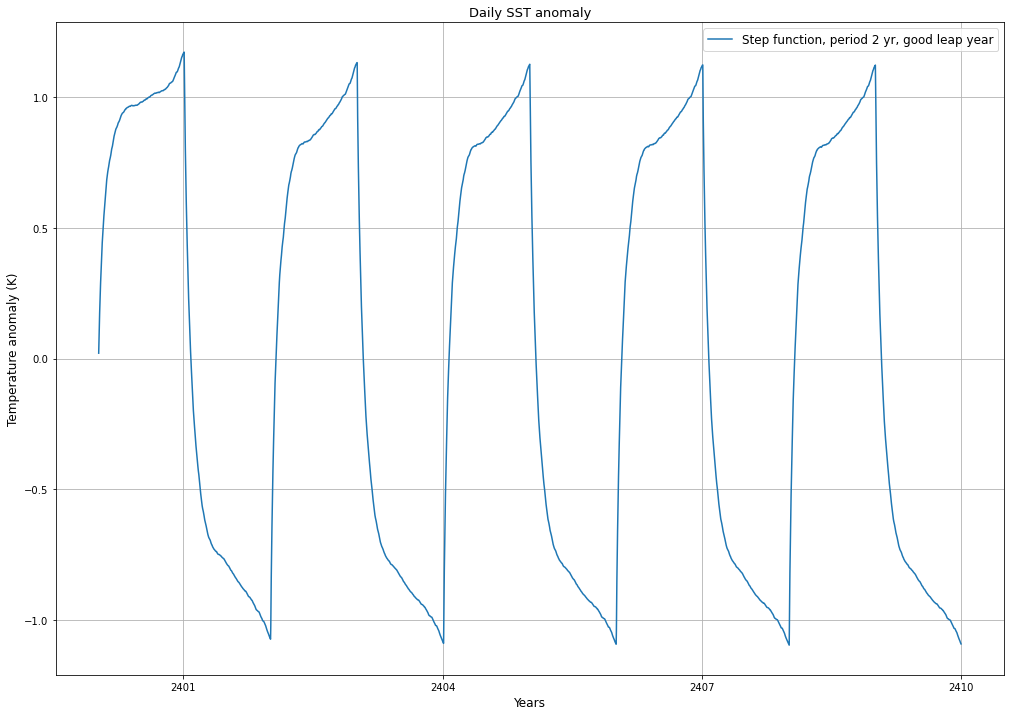

In [80]:
plt.figure(figsize = (17,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})

# step_test_anom_plot = xr.concat([zero, SST_step_test[:,0] - SST_cont[:,0]], dim='year')
step_test2_anom_plot = (SST_step_test2[6:,0] - SST_cont[6:,0])#[:-1].groupby('time.year').mean(dim='time')

step_test2_anom_plot.plot(label='Step function, period 2 yr, good leap year')


plt.title('Daily SST anomaly', fontsize=13)
plt.ylabel('Temperature anomaly (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
#plt.savefig('SST_step_test.jpg')

In [23]:
import cftime
x = (SST_step_test2 - SST_cont).sel(time = slice(cftime.DatetimeNoLeap(2424, 8, 22, 0, 0, 0, 0), cftime.DatetimeNoLeap(2424, 8, 30, 0, 0, 0, 0)))
x, x['time']

(<xarray.DataArray 'temp_surface_ave' (time: 0, scalar_axis: 1)>
 array([], shape=(0, 1), dtype=float64)
 Coordinates:
   * time         (time) object 
   * scalar_axis  (scalar_axis) float64 0.0,
 <xarray.DataArray 'time' (time: 0)>
 array([], dtype=object)
 Coordinates:
   * time     (time) object 
 Attributes:
     long_name:       time
     cartesian_axis:  T
     calendar_type:   NOLEAP)

In [24]:
y = (temp_step_test2_ave - temp_cont_ave).sel(time = slice(cftime.DatetimeNoLeap(2424, 6, 1, 0, 0, 0, 0), cftime.DatetimeNoLeap(2424, 12, 31, 0, 0, 0, 0)))
y

<xarray.DataArray (time: 0)>
array([], dtype=float32)
Coordinates:
  * time     (time) object

In [25]:
expt = '1deg_jra55_ryf_wcwc_step_test2'
var = 'total_ocean_lw_heat'
SST_step_test_lw = cc.querying.getvar(expt, var, session, start_time = yr_beg).load()

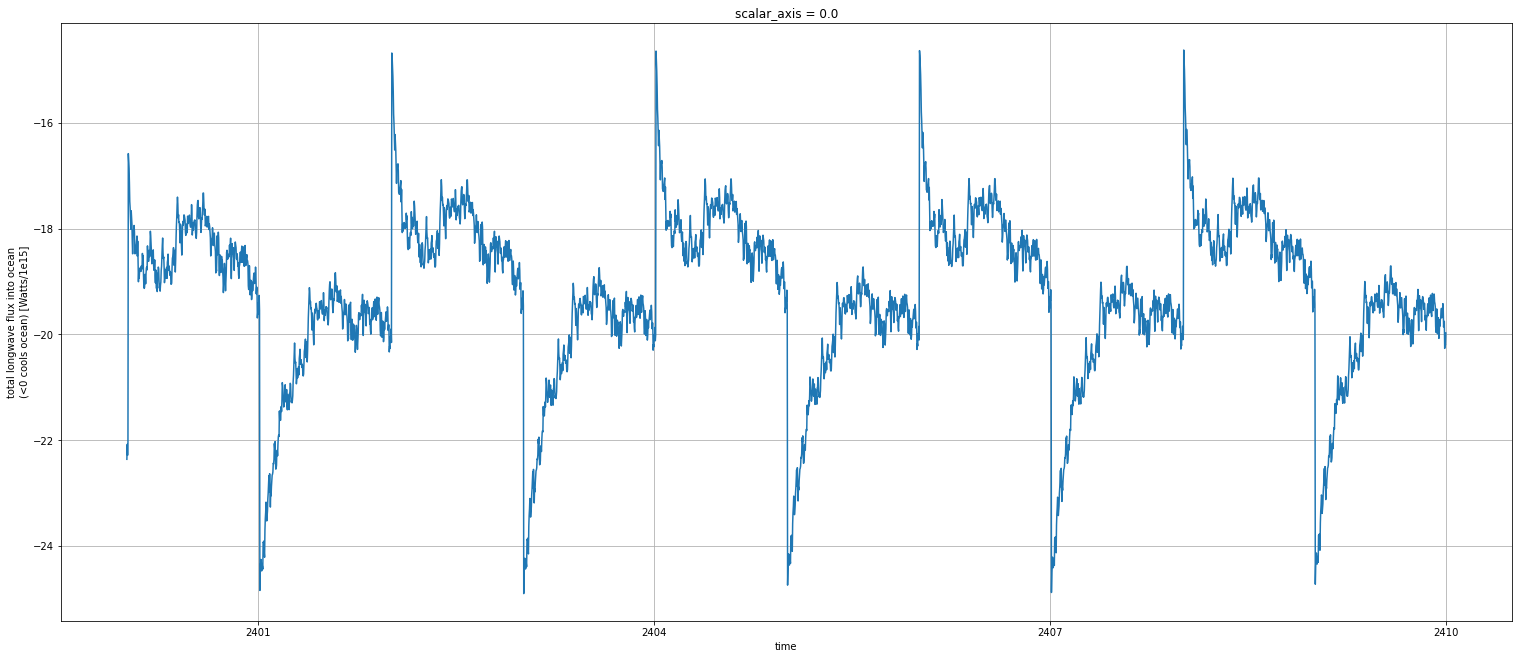

In [26]:
plt.figure(figsize=(26,11))
SST_step_test_lw.plot()#.sel(time=slice(cftime.DatetimeNoLeap(2404, 1, 1, 0, 0, 0, 0), cftime.DatetimeNoLeap(2405, 1, 1, 0, 0, 0, 0))).plot()
plt.grid()

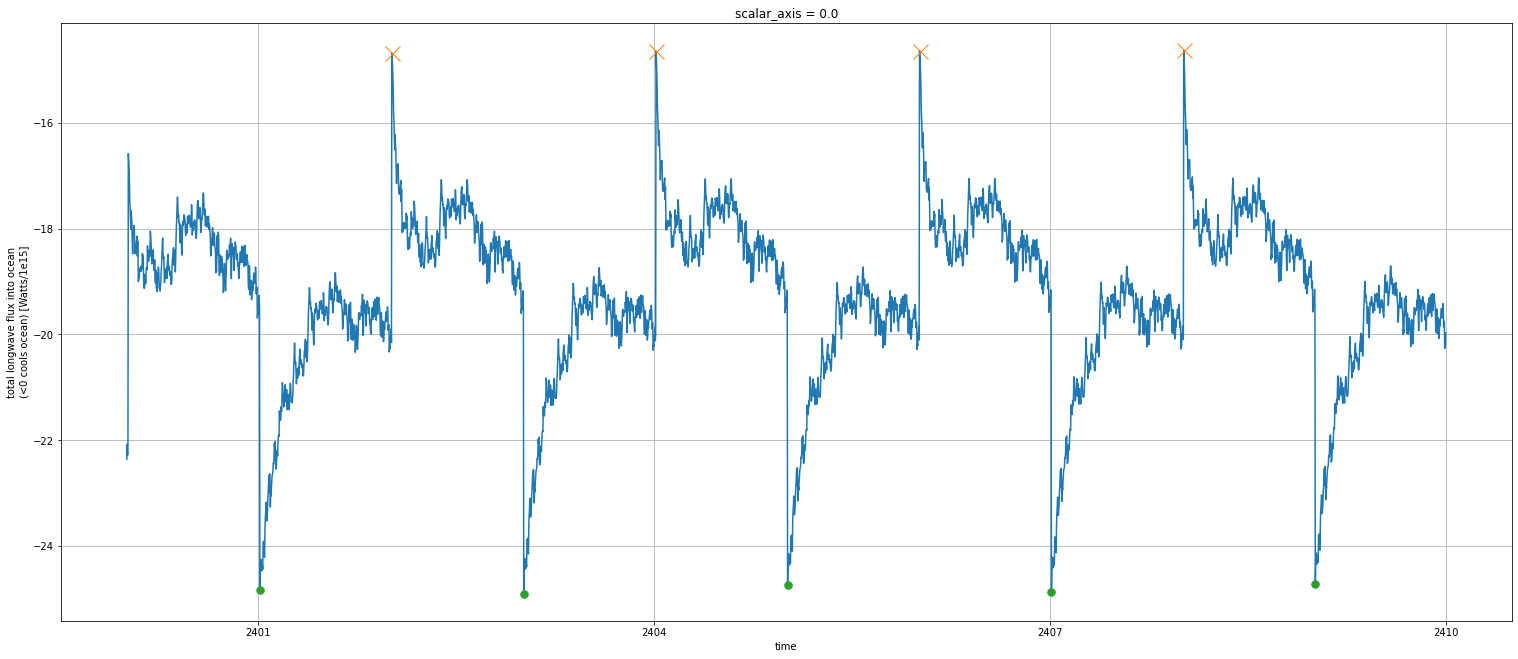

('minima at:',
 array([cftime.DatetimeNoLeap(2401, 1, 5, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2403, 1, 5, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2405, 1, 5, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2407, 1, 5, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2409, 1, 5, 0, 0, 0, 0)], dtype=object),
 'maxima at:',
 array([cftime.DatetimeNoLeap(2402, 1, 5, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2404, 1, 6, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2406, 1, 5, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2408, 1, 6, 0, 0, 0, 0)], dtype=object))

In [48]:
from scipy.signal import find_peaks

plt.figure(figsize=(26,11))
maxes, _ = find_peaks(SST_step_test_lw[:,0], height=-16)
mins, _ = find_peaks(-1*SST_step_test_lw[:,0], height=24.5)
SST_step_test_lw[:,0].plot()
plt.plot(SST_step_test_lw['time'][maxes].values, SST_step_test_lw[:,0][maxes], "x", markersize=15)
plt.plot(SST_step_test_lw['time'][mins].values, SST_step_test_lw[:,0][mins], ".", markersize=15)
plt.grid()
plt.show()
'minima at:', SST_step_test_lw['time'][mins].values, 'maxima at:', SST_step_test_lw['time'][maxes].values 

In [62]:
SST_step_test_lw['time'][:5]

<xarray.DataArray 'time' (time: 5)>
array([cftime.DatetimeNoLeap(2400, 1, 2, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2400, 1, 3, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2400, 1, 4, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2400, 1, 5, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2400, 1, 6, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2400-01-02 00:00:00 ... 2400-01-06 00:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP

In [52]:
SST_step_test_lw[maxes]

<xarray.DataArray 'total_ocean_lw_heat' (time: 4, scalar_axis: 1)>
array([[-14.68090112],
       [-14.64405078],
       [-14.63612476],
       [-14.6244766 ]])
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) object 2402-01-05 00:00:00 ... 2408-01-06 00:00:00
Attributes:
    long_name:     total longwave flux into ocean (<0 cools ocean)
    units:         Watts/1e15
    valid_range:   [-1.e+10  1.e+10]
    cell_methods:  time: point

In [ ]:
plt.figure(figsize = (17,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})

RCPcool_humid_x1_anom_plot = xr.concat([zero, SST_RCPcool_humid_x1[:,0] - SST_cont[:,0]], dim='year')
RCPcool_humid_x2_anom_plot = xr.concat([zero, SST_RCPcool_humid_x2[:,0] - SST_cont[:,0]], dim='year')
RCPwarm_humid_x1_anom_plot = xr.concat([zero, SST_RCPwarm_humid_x1[:,0] - SST_cont[:,0]], dim='year')
RCPwarm_humid_x2_anom_plot = xr.concat([zero, SST_RCPwarm_humid_x2[:,0] - SST_cont[:,0]], dim='year')

(- 1 * RCPcool_humid_x1_anom_plot).plot(label='Cooling x$-1$', color = 'b')
(- 0.5 * RCPcool_humid_x2_anom_plot).plot(label='Double cooling x$-0.5$', color = 'b', linestyle = '--')
RCPwarm_humid_x1_anom_plot.plot(label='Warming', color = 'r')
(0.5 * RCPwarm_humid_x2_anom_plot).plot(label='Double warming x$0.5$', color = 'r', linestyle = '--')

plt.title('SST anomaly', fontsize=13)
plt.ylabel('Temperature anomaly (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
#plt.savefig('SST_good_perturbation.jpg')

### Calculate total ocean heat content from conservative temperature

In [8]:
rho_0 = 1030 #kg/m^3
c_p = 3992 #J/kg/K

In [9]:
expt = '1deg_jra55_ryf_cont'
dzt = cc.querying.getvar(expt, 'dzt', session, start_time = yr_beg)
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) #Volume of cells
heat_cont = rho_0 * c_p * (temp_cont * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean'])

In [35]:
# expt = '1deg_jra55_ryf_rcp45cool_spinup500'
# dzt = cc.querying.getvar(expt, 'dzt', session) #thickness of cells
# area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
# dVol = (dzt * area_t) #Volume of cells
# heat_cool = rho_0 * c_p * (temp_cool * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean'])

In [36]:
# expt = '1deg_jra55_ryf_rcp45warm_spinup500'
# dzt = cc.querying.getvar(expt, 'dzt', session) #thickness of cells
# area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
# dVol = (dzt * area_t) #Volume of cells
# heat_warm = rho_0 * c_p * (temp_warm * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean'])

In [26]:
expt = '1deg_jra55_ryf_rcp45cool_x1_spinup500'
dzt = cc.querying.getvar(expt, 'dzt', session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) #Volume of cells
heat_coolx1 = rho_0 * c_p * (temp_coolx1 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean'])

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 559, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22783579019072 and this is thread id 22779092530944.
Exception closing connection <sqlite3.Connection object at 0x14b816fef3f0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/sqlalchemy/po

In [27]:
expt = '1deg_jra55_ryf_rcp45warm_x1_spinup500'
dzt = cc.querying.getvar(expt, 'dzt', session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) #Volume of cells
heat_warmx1 = rho_0 * c_p * (temp_warmx1 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean'])

In [10]:
expt = '1deg_jra55_ryf_rcp45cool_x2_spinup500'
dzt = cc.querying.getvar(expt, 'dzt', session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) #Volume of cells
heat_coolx2 = rho_0 * c_p * (temp_coolx2 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean'])

In [11]:
expt = '1deg_jra55_ryf_rcp45warm_x2_spinup500'
dzt = cc.querying.getvar(expt, 'dzt', session) #thickness of cells
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # area of cells
dVol = (dzt * area_t) #Volume of cells
heat_warmx2 = rho_0 * c_p * (temp_warmx2 * dVol).sum(dim = ['xt_ocean', 'yt_ocean', 'st_ocean'])

In [12]:
# Yearly average

heat_cont = heat_cont.groupby('time.year').mean(dim='time').load()
heat_coolx2 = heat_coolx2.groupby('time.year').mean(dim='time').load()
heat_warmx2 = heat_warmx2.groupby('time.year').mean(dim='time').load()

In [29]:
heat_coolx1 = heat_coolx1.groupby('time.year').mean(dim='time').load()
heat_warmx1 = heat_warmx1.groupby('time.year').mean(dim='time').load()

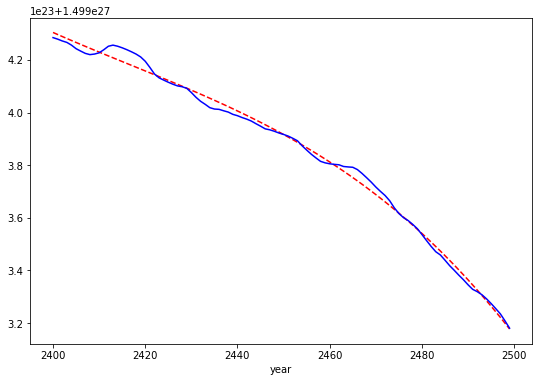

In [49]:
# Trend in control heat content: fit a cubic

def cubic(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

t = heat_cont['year']
popt, pcov = curve_fit(cubic, t, heat_cont / 1e27)
heat_trend = cubic(t, *popt) * 1e27

plt.figure(figsize=(9,6))
(heat_trend).plot(color='r', linestyle='--')
heat_cont.plot(color='b')

#### Plotting ocean heat content over time

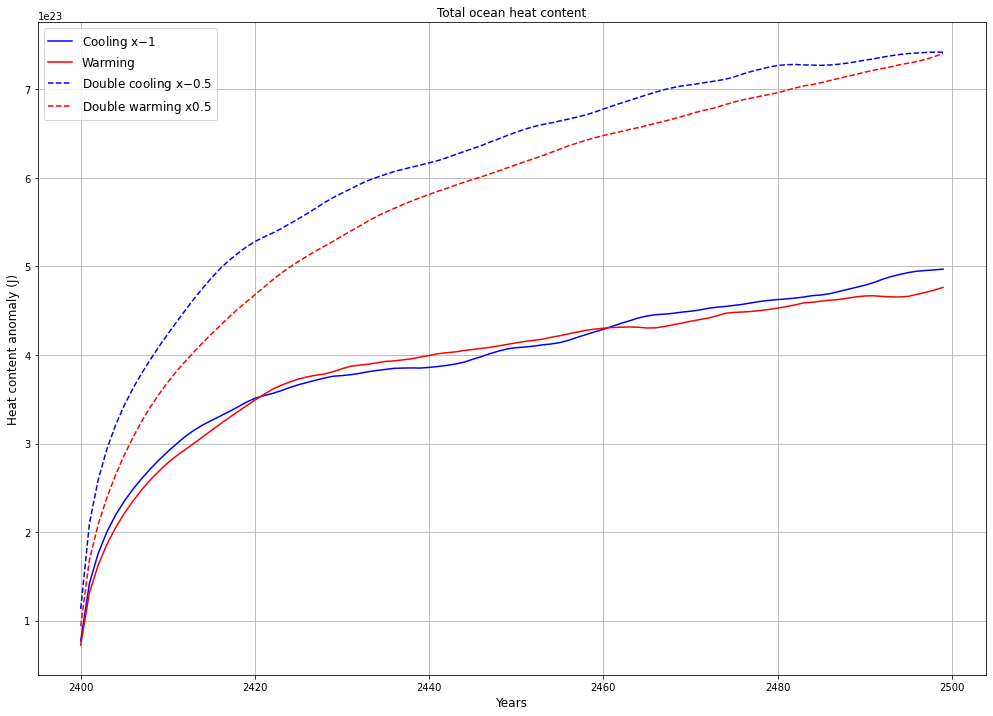

In [36]:
plt.figure(figsize = (17,12))

(-1 * (heat_coolx1 - heat_cont)).plot(label='Cooling x$-1$', color = 'b')
(heat_warmx1 - heat_cont).plot(label='Warming', color = 'r')
(-0.5 * (heat_coolx2 - heat_cont)).plot(label='Double cooling x$-0.5$', color = 'b', linestyle='--')
(0.5 * (heat_warmx2 - heat_cont)).plot(label='Double warming x$0.5$', color = 'r', linestyle='--')
plt.title('Total ocean heat content')
plt.ylabel('Heat content anomaly (J)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
#plt.savefig('total_heat_content.jpg')

### Calculate horizontally-averaged temperature

In [7]:
def area_weighted_ave(tracer, expt):
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1).load() # area of cells
    area_total = area_t.sum(dim=('xt_ocean', 'yt_ocean')) # total area of ocean
    
    return (area_t * tracer).sum(dim=('xt_ocean', 'yt_ocean')) / area_total

In [8]:
temp_cool_horizontal_ave_anom = area_weighted_ave(temp_cool - temp_cont, '1deg_jra55_ryf_RCPcool_humid_x1').groupby('time.year').mean(dim='time').load()
temp_warm_horizontal_ave_anom = area_weighted_ave(temp_warm - temp_cont, '1deg_jra55_ryf_RCPwarm_humid_x1').groupby('time.year').mean(dim='time').load()

In [9]:
print('yes')

yes


In [80]:
year_index = 2

largest_anom_difference_arg = np.where(-1 * temp_cool_horizontal_ave_anom.isel(year=year_index) - temp_warm_horizontal_ave_anom.isel(year=year_index) \
         == np.max(-1 * temp_cool_horizontal_ave_anom.isel(year=year_index) - temp_warm_horizontal_ave_anom.isel(year=year_index)))[0]

np.max(-1 * temp_cool_horizontal_ave_anom.isel(year=year_index) - temp_warm_horizontal_ave_anom.isel(year=year_index))
temp_warm_horizontal_ave_anom['st_ocean']
temp_warm_horizontal_ave_anom['st_ocean'][20]
(-1 * temp_cool_horizontal_ave_anom - temp_warm_horizontal_ave_anom).isel(year=year_index, st_ocean = 23)

<xarray.DataArray ()>
array(0.02376734, dtype=float32)
Coordinates:
    year      int64 2402
    st_ocean  float64 502.3

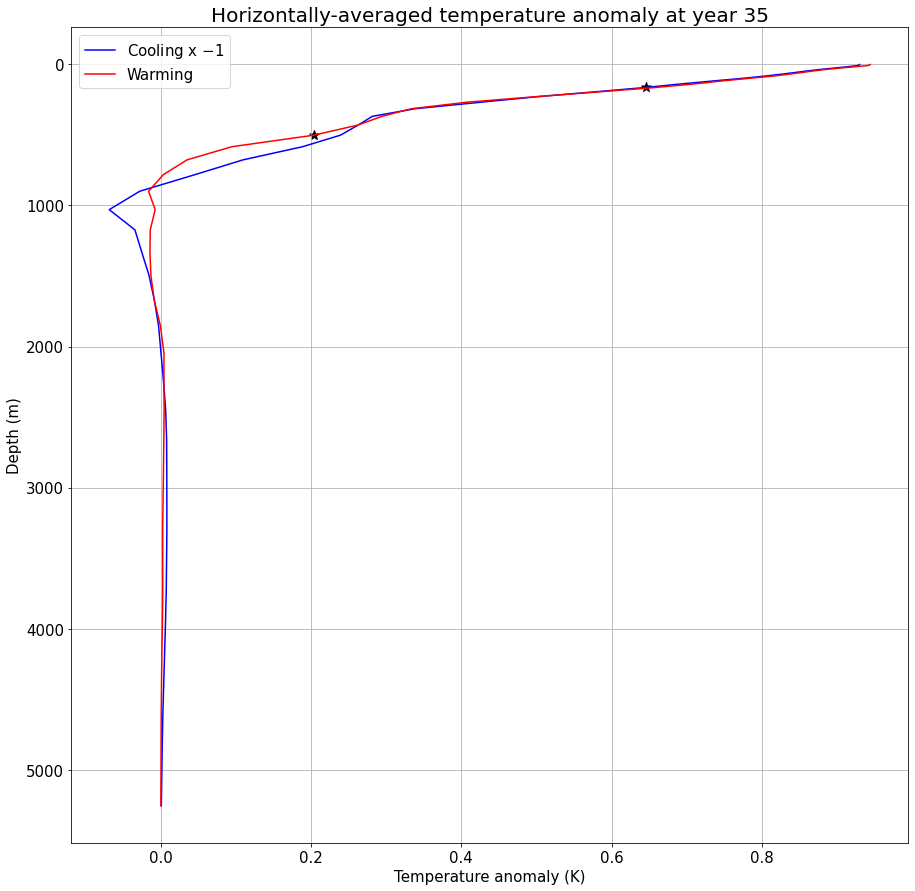

In [92]:
plt.figure(figsize=(15,15))

year_index = 35
depth_index = largest_anom_difference_arg

plt.scatter(-1*temp_cool_horizontal_ave_anom.isel(year=year_index, st_ocean = depth_index), temp_cool_horizontal_ave_anom['st_ocean'][depth_index], s=100, color='k', marker='*')
plt.scatter(temp_warm_horizontal_ave_anom.isel(year=year_index, st_ocean = 23), temp_warm_horizontal_ave_anom['st_ocean'][23], s=100, color='k', marker='*')

plt.plot(-1 * temp_cool_horizontal_ave_anom.isel(year=year_index).values, temp_cool_horizontal_ave_anom['st_ocean'], label='Cooling x $-1$', color = 'b')
plt.plot(temp_warm_horizontal_ave_anom.isel(year=year_index).values, temp_warm_horizontal_ave_anom['st_ocean'], label='Warming', color = 'r')


plt.title(f'Horizontally-averaged temperature anomaly at year {year_index}', fontsize=20)
plt.ylabel('Depth (m)', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Temperature anomaly (K)', fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.gca().invert_yaxis()
# plt.savefig(f'vertical_temperature_anom_year{year_index}.jpg')